In [1]:
import torch
from torch import nn

import math
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(111)    # to allow replication on different machines

In [3]:
# Prepare the training data
# (x1, x2) - x2 = sine(x1), x1 in range [0, 2pi]
train_data_length = 1024                                                   # set of 1024 pairs
train_data = torch.zeros((train_data_length, 2))                           # initialize tensor with dimensions 1024 rows x 2 columns, filled with zeros
train_data[:, 0] = 2 * math.pi * torch.rand(train_data_length)             # store random values in range [0, 2pi]
train_data[:, 1] = torch.sin(train_data[:, 0])                             # calculate sine of column 1
train_labels = torch.zeros(train_data_length)                              # labels required by default by PyTorch's data loader
train_set = [                                                              # prepare tuples for PyTorch data loader
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

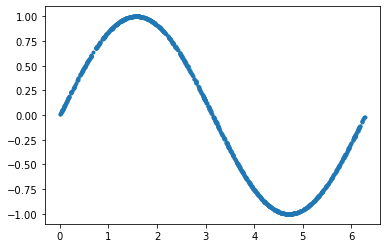

In [4]:
plt.plot(train_data[:, 0], train_data[:, 1], ".")     # plot training data

In [5]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(              # shuffles train_set and returns batches of 32 samples to be used in neural network
    train_set, batch_size=batch_size, shuffle=True
)

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(         # MLP neural network defined sequentially
            nn.Linear(2, 256),              # two-dimensional input with 256 neurons in first hidden layer
            nn.ReLU(),                      # rectifier for activation function
            nn.Dropout(0.3),                # dropouts used to avoid overfitting
            nn.Linear(256, 128),            # second hidden layer - 128 neurons
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),             # third hidden layer - 64 neurons
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),               # single output
            nn.Sigmoid(),                   # sigmoid activation function for output to represent a probability
        )
    
    def forward(self, x):
        output = self.model(x)              # output obtained without additional processing
        return output

In [9]:
discriminator = Discriminator()             # instance of neural network that is ready to be trained

In [10]:
# Implement the Generator
# two-dimensional input, random points (z1, z2) from latent space
# two-dimensional output (xg1, xg2) resembling those from training data
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),               # two hidden layers with 16 and 32 neurons, respectively
            nn.ReLU(),                      # rectifier activation
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),               # linear activaton layer with 2 neurons in output (xg1, xg2)
        )
    
    def forward(self, x):
        output = self.model(x)
        return output

In [11]:
generator = Generator()

In [12]:
# Train the Models
lr = 0.001                       # learning rate to adapt network weights
num_epochs = 300                 # repetitions of training
loss_function = nn.BCELoss()     # Binary Cross-Entropy for loss function - suitable because it considers a binary classification task
                                 # and discriminator provides binary observable output

In [13]:
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)   # Adaptive Moment Estimation to train both neural networks
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [15]:
# implement training loop to feed samples and update weights to minimize the loss function
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):     # get real samples of current batch from data loader; each line of tensor represents one sampel from batch
        
        # data to train discriminator
        real_samples_labels = torch.ones((batch_size, 1))              # 1 for real samples
        latent_space_samples = torch.randn((batch_size, 2))
        generated_samples = generator(latent_space_samples)            # feed random data to generator to get generated samples
        generated_samples_labels = torch.zeros((batch_size, 1))        # 0 for generated samples
        all_samples = torch.cat((real_samples, generated_samples))     # combine real and generated samples to feed to discriminator
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        # train the discriminator
        discriminator.zero_grad()                             # clear gradients at each training step to avoid accumulation
        output_discriminator = discriminator(all_samples)     # calculate output of discriminator
        loss_discriminator = loss_function(output_discriminator, all_samples_labels)     # calculate loss function
        loss_discriminator.backward()              # calculate gradients
        optimizer_discriminator.step()             # update discriminator weights
        
        # data to train generator
        latent_space_samples = torch.randn((batch_size, 2))   # two-dimensional input to generator
        
        # train the generator
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)   # generate samples from latente space
        output_discriminator_generated = discriminator(generated_samples)     # get output of generated samples from discriminator
        loss_generator = loss_function(output_discriminator_generated, real_samples_labels)   # calculate loss function; all labels equal to 1
        loss_generator.backward()                  # calculate gradients
        optimizer_generator.step()                 # update generator weights; discriminator weights frozen
        
        # display loss functions for every ten epochs
        if epoch % 10 == 0 and n == batch_size - 1:
            print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
            print(f"Epoch: {epoch} Loss G.: {loss_generator}")

Epoch: 0 Loss D.: 0.16663309931755066
Epoch: 0 Loss G.: 2.0519187450408936
Epoch: 10 Loss D.: 0.6624932289123535
Epoch: 10 Loss G.: 0.8620059490203857
Epoch: 20 Loss D.: 0.6294434070587158
Epoch: 20 Loss G.: 0.8032889366149902
Epoch: 30 Loss D.: 0.5289642214775085
Epoch: 30 Loss G.: 1.1769884824752808
Epoch: 40 Loss D.: 0.5814887881278992
Epoch: 40 Loss G.: 0.8989247679710388
Epoch: 50 Loss D.: 0.6534417271614075
Epoch: 50 Loss G.: 0.8726067543029785
Epoch: 60 Loss D.: 0.6189590692520142
Epoch: 60 Loss G.: 0.9972568154335022
Epoch: 70 Loss D.: 0.693320631980896
Epoch: 70 Loss G.: 0.7426339387893677
Epoch: 80 Loss D.: 0.6420703530311584
Epoch: 80 Loss G.: 0.7834144234657288
Epoch: 90 Loss D.: 0.6438316702842712
Epoch: 90 Loss G.: 0.7330536842346191
Epoch: 100 Loss D.: 0.7094649076461792
Epoch: 100 Loss G.: 0.6829090118408203
Epoch: 110 Loss D.: 0.7072309851646423
Epoch: 110 Loss G.: 0.7929078340530396
Epoch: 120 Loss D.: 0.6215538382530212
Epoch: 120 Loss G.: 0.7684662938117981
Epoch: 1

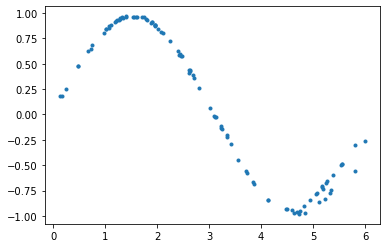

In [16]:
# observe if generated samples of trained generator look like sine curve
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)

generated_samples = generated_samples.detach()         # return tensor from PyTorch computational graph
plt.plot(generated_samples[:, 0], generated_samples[:, 1], ".")